# Defect analysis

This toolbox comes with automated inspection models as well. Here, we demonstrate the built-in weakly-supervised classification of cracks on solar cells.

*Disclaimer:* Deep Learning Models are known to generalize badly. This model was already trained on the training subset of the demonstrated ELPV dataset. Thus, it performs quite well on that data. However, it is very likely that it does not perform well on different data. To improve the performance on a new dataset, please use fine-tuning. A tutorial how to fine-tune the given model will follow.

In [1]:
import pvinspect as pv
from sklearn.metrics import classification_report
from pvinspect import analysis
from pathlib import Path
import pandas as pd

First of all, we need to instanciate the model. Here, we choose to use our GPU to speed up computation. Of course, this can be disabled as well:

In [2]:
model = pv.analysis.factory_models.defects(use_cuda=True)

Next, we load the test subset from the ELPV dataset:

In [3]:
data = pv.data.datasets.elpv().pandas.query("testset == True")

Classifying and segmenting the samples is now as easy as

In [4]:
res = model.apply(data)

100%|██████████| 300/300 [00:06<00:00, 42.94it/s]


## Results

Let's investigate the results. PVInspect comes with a ``ShowPlugin`` that already highlights the defects found be weakly-supervised localization. First, we consider some examples that have are predicted to have a crack with a probability of less the 50%:

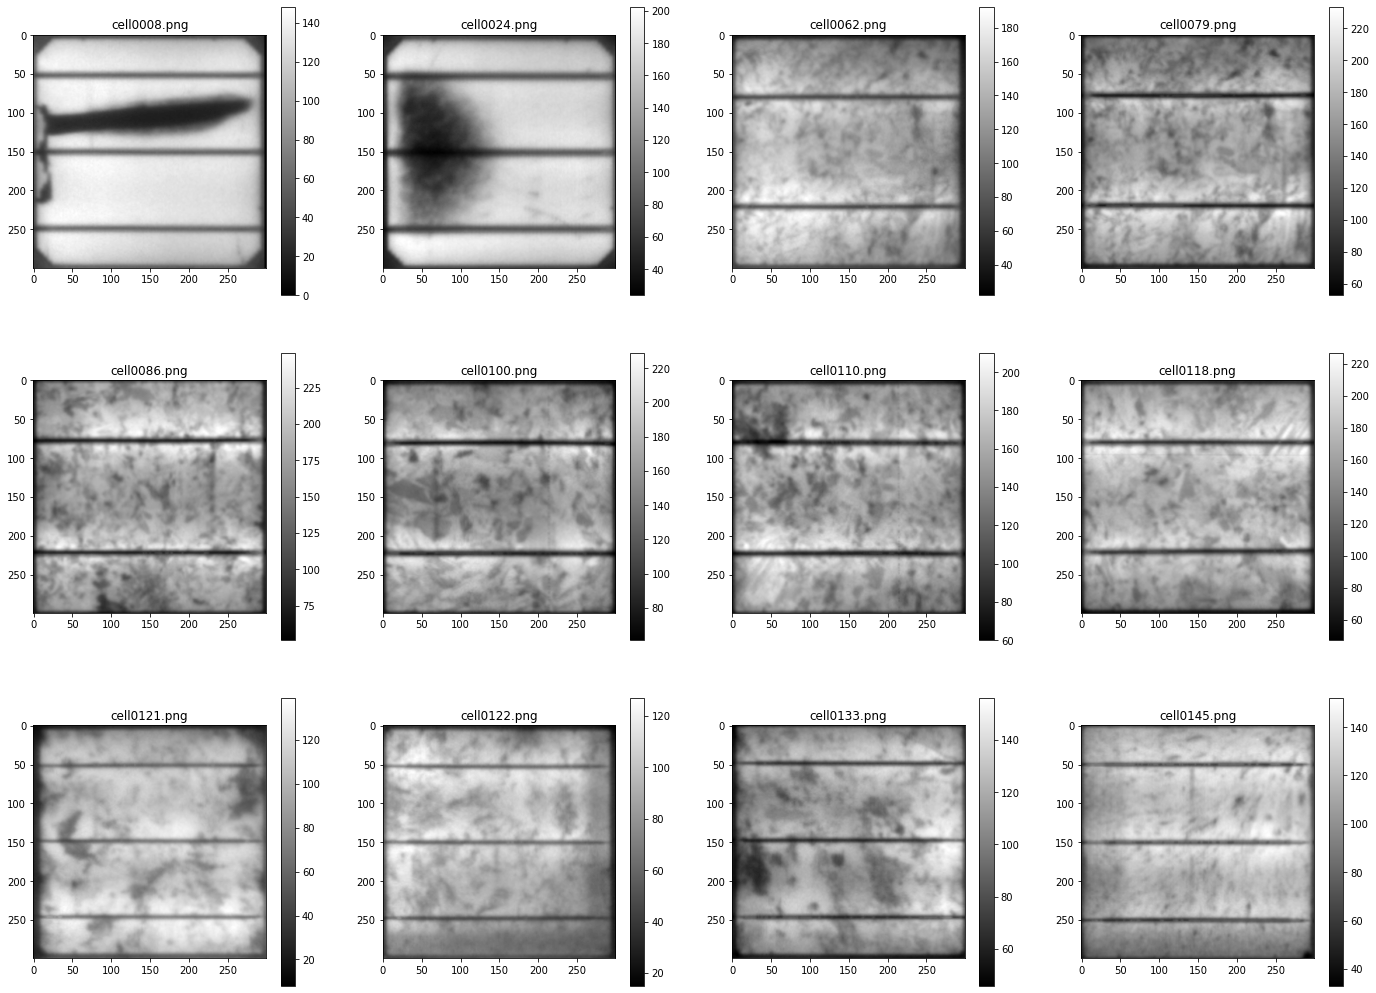

In [5]:
res.pandas.query("pred_crack_p < 0.5").head(N=12, cols=4)

Next, let's investigate the examples with a crack probability of more than 50%:

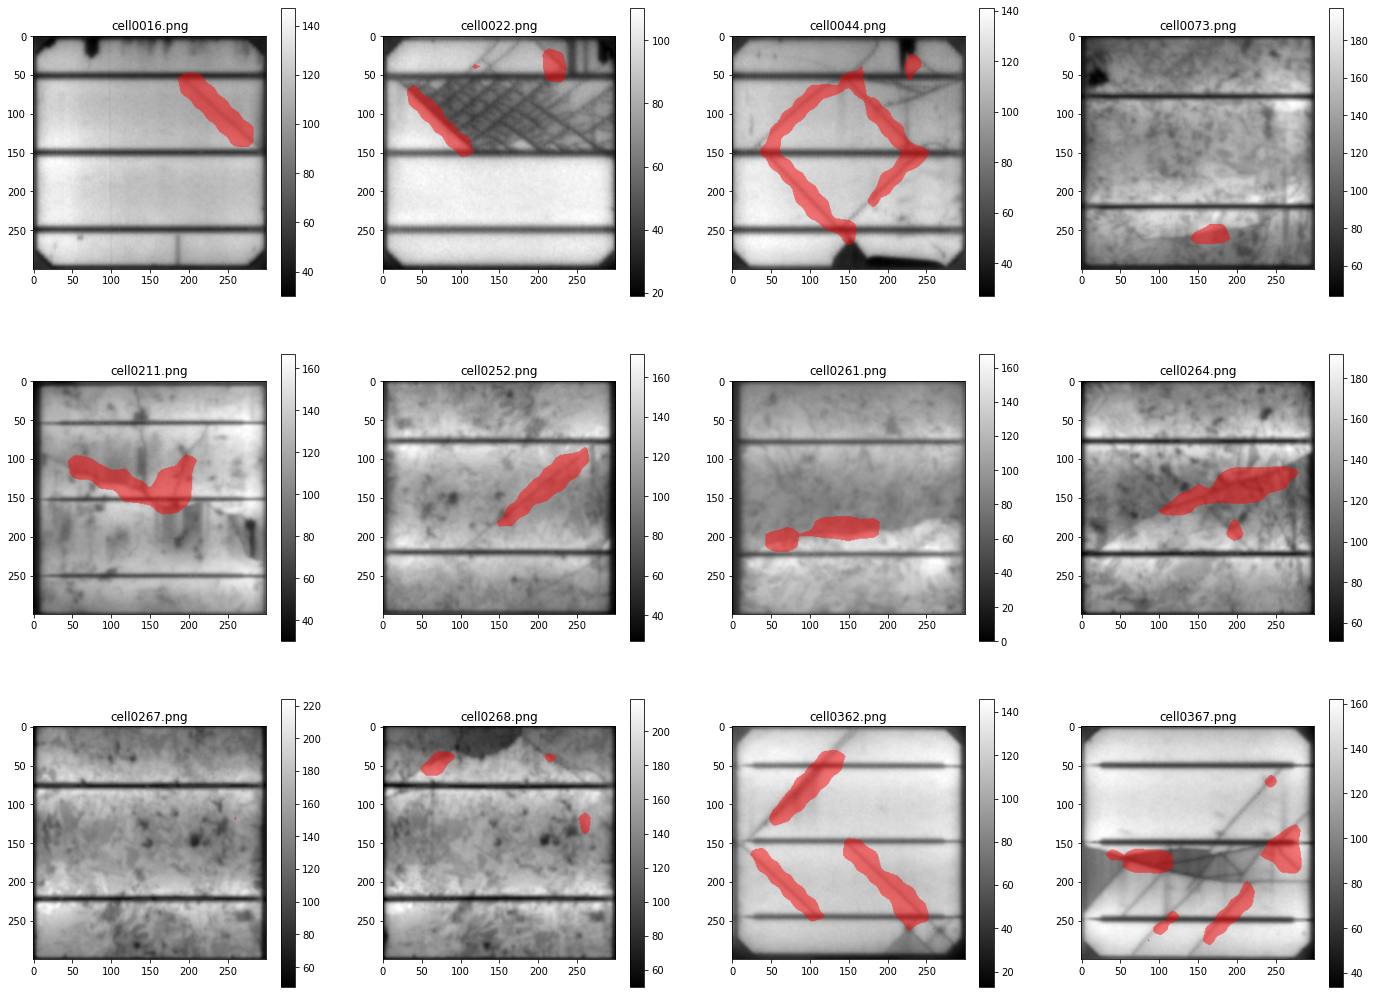

In [6]:
res.pandas.query("pred_crack_p > 0.5").head(N=12, cols=4)

## Quantitative analysis

The classification results are stored as meta data of the image sequence. Let's consider a single example first:

In [7]:
res[0].meta

original_filename                                          cell0008.png
modality                                                       EL_IMAGE
defect_probability                                                    1
wafer                                                              mono
crack                                                             False
inactive                                                          False
blob                                                               True
finger                                                            False
testset                                                            True
pred_crack_p                                                   0.415801
pred_inactive_p                                                0.649799
pred_crack_cam        [[2.0942274e-05, 1.2078529e-05, 1.5686244e-05,...
pred_inactive_cam     [[4.766371e-06, 1.2716289e-06, 1.2612759e-06, ...
Name: 0, dtype: object

The predictions by our model are added to the existing meta data with the prefix ``pred_``. Specifically, we have the predicted probabilities (``*_p``) as well as the class activation maps (``*_cam``) available. Furthermore, we also have the annotations from the dataset. Those can be used to compute the quantitative results:

In [8]:
pd.DataFrame(classification_report(res.meta[["crack", "inactive"]], res.meta[["pred_crack_p", "pred_inactive_p"]] > 0.5, target_names=["crack", "inactive"], output_dict=True, zero_division=0))

,crack,inactive,micro avg,macro avg,weighted avg,samples avg
precision,0.894737,0.812500,0.876712,0.853618,0.879179,0.166667
recall,0.850000,0.928571,0.864865,0.889286,0.864865,0.168333
f1-score,0.871795,0.866667,0.870748,0.869231,0.870825,0.166667
support,60.000000,14.000000,74.000000,74.000000,74.000000,74.000000
